# Maximum Flow Problem

La capacidad vehicular se medirá mediante un relación inversa del tiempo de viaje. Se asume que mientras más tiempo de viaje, más congestión vehicular y menor capacidad.

$capacidad = \frac{1}{t}$

In [3]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

## Grafo de tiempo

In [4]:
time_data = pd.read_csv('time_matrix.csv')

In [5]:
time_matrix = time_data.iloc[:,1:].values

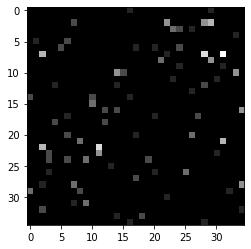

In [6]:
plt.imshow(time_matrix,'gray')

In [7]:
time_graph = nx.DiGraph(time_matrix)

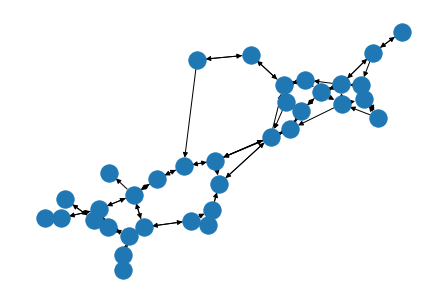

In [8]:
nx.draw_kamada_kawai(time_graph)

In [9]:
time_graph.edges[(0,16)]

{'weight': 1.0}

## Grafo de capacidad

In [10]:
data_point = pd.read_csv('centros_googleApi')

In [11]:
centros = list(data_point['cluster_point'])

In [12]:
graph = nx.DiGraph()
pos_graph = []
lab_dict = {}
for i,centro in enumerate(centros):
    graph.add_node(i)
    lab_dict[i] = str(i)
    pos = centro.replace('(','').replace(')','').split(',')
    x = float(pos[0])
    y = float(pos[1])
    pos_graph.append((x,y))
    graph.nodes[i]['x'] = x
    graph.nodes[i]['y'] = y

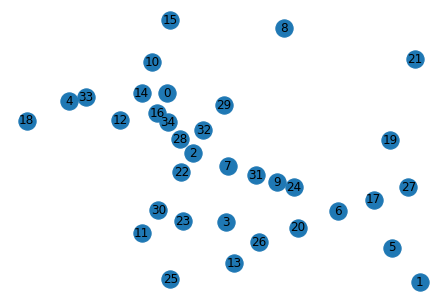

In [13]:
nx.draw(graph,pos_graph,labels=lab_dict,
       with_labels=True)

In [14]:
for edge in time_graph.edges:
    capacity = 1/time_graph.edges[edge]['weight'] #uno sobre tiempo
    graph.add_edge(edge[0],edge[1],capacity=capacity)

In [15]:
graph.edges[(0,16)]

{'capacity': 1.0}

In [16]:
time_graph.edges[(0,16)]

{'weight': 1.0}

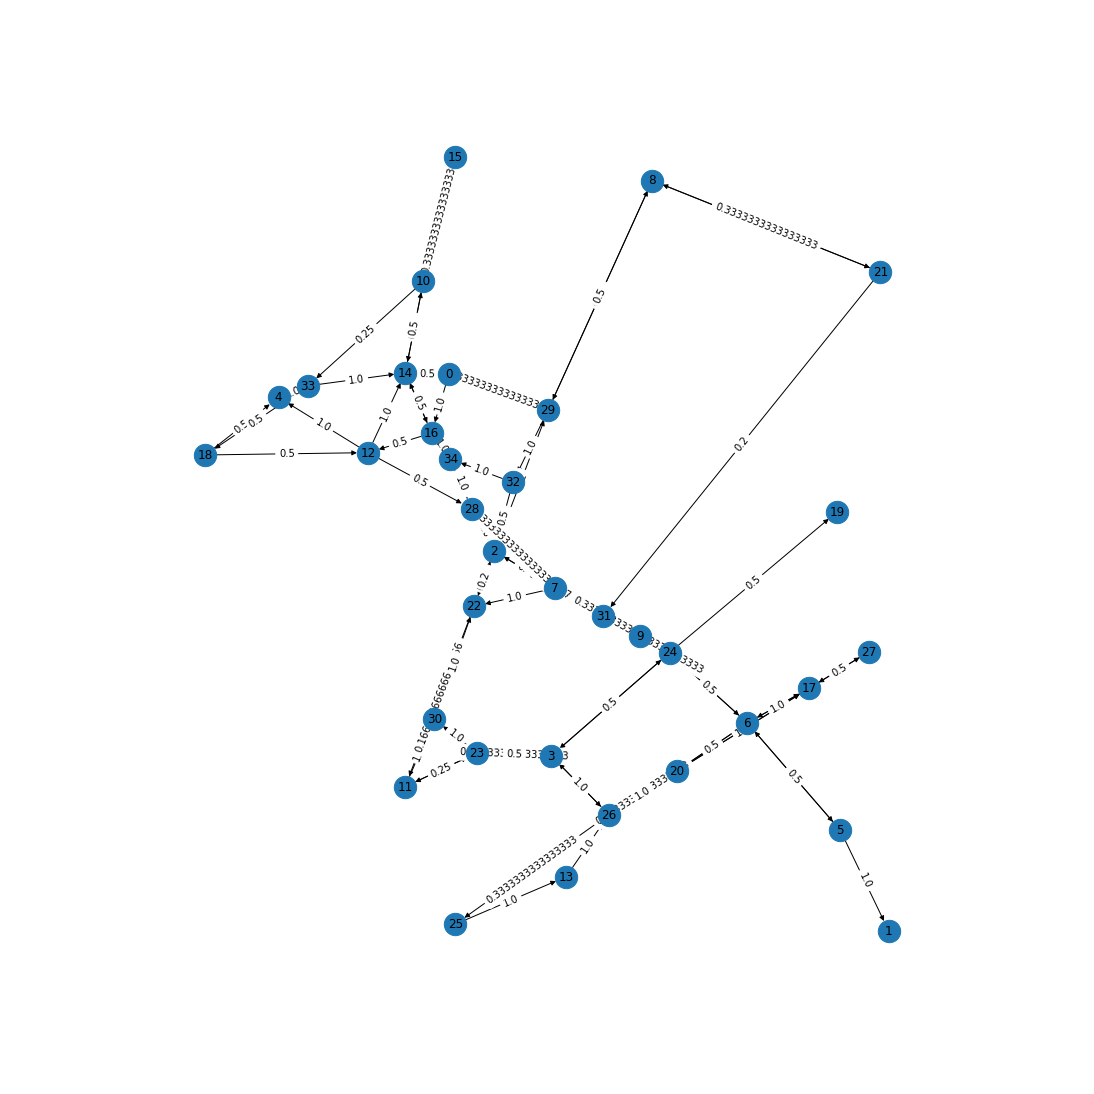

In [17]:
plt.figure(figsize=(15,15))
dis_dic = nx.get_edge_attributes(graph,'capacity')

nx.draw(graph,pos_graph,
            node_size=500,
            labels=lab_dict, 
            with_labels = True)

nx.draw_networkx_edge_labels(graph,pos_graph,edge_labels=dis_dic)

plt.show()

In [19]:
graph.edges[(15,10)]

{'capacity': 0.3333333333333333}

In [18]:
solucion = nx.maximum_flow(graph,15,11)

In [32]:
solucion[1]

{0: {16: 0.14285714285714285, 29: 0.10714285714285715},
 1: {},
 2: {7: 0.19047619047619047, 22: 0.14285714285714285, 28: 0, 29: 0},
 3: {23: 0.16666666666666666, 24: 0, 26: 0},
 4: {33: 0},
 5: {1: 0, 6: 0},
 6: {5: 0, 17: 0, 20: 0, 24: 0},
 7: {2: 0,
  22: 0.023809523809523808,
  28: 0.023809523809523808,
  31: 0.14285714285714285},
 8: {21: 0.023809523809523808, 29: 0},
 9: {24: 0.16666666666666666, 31: 0},
 10: {14: 0.25, 15: 0, 33: 0.08333333333333331},
 11: {23: 0, 30: 0},
 12: {4: 0, 14: 0, 28: 0.24999999999999997},
 13: {26: 0},
 14: {0: 0.25, 10: 0, 16: 0},
 15: {10: 0.3333333333333333},
 16: {12: 0.16666666666666666, 14: 0, 34: 0},
 17: {6: 0, 20: 0, 27: 0},
 18: {4: 0, 12: 0.08333333333333331},
 19: {},
 20: {6: 0, 17: 0, 26: 0},
 21: {8: 0, 31: 0.023809523809523808},
 22: {2: 0, 11: 0.16666666666666666},
 23: {3: 0, 11: 0.16666666666666666, 30: 0},
 24: {3: 0.16666666666666666, 6: 0, 9: 0, 19: 0},
 25: {13: 0},
 26: {3: 0, 20: 0, 25: 0},
 27: {17: 0},
 28: {2: 0.24999999999

In [84]:
graph_sol = nx.DiGraph(solucion[1])

In [85]:
remove_edges = []
good_nodes = []
for edge in graph_sol.edges:
    capacity = solucion[1][edge[0]][edge[1]]
    if(capacity==0):
        remove_edges.append(edge)
    else:
        graph_sol.edges[edge]['capacity'] = round(capacity,3)
        good_nodes.append(edge[1])

In [86]:
for edge in remove_edges:
    graph_sol.remove_edge(edge[0],edge[1])

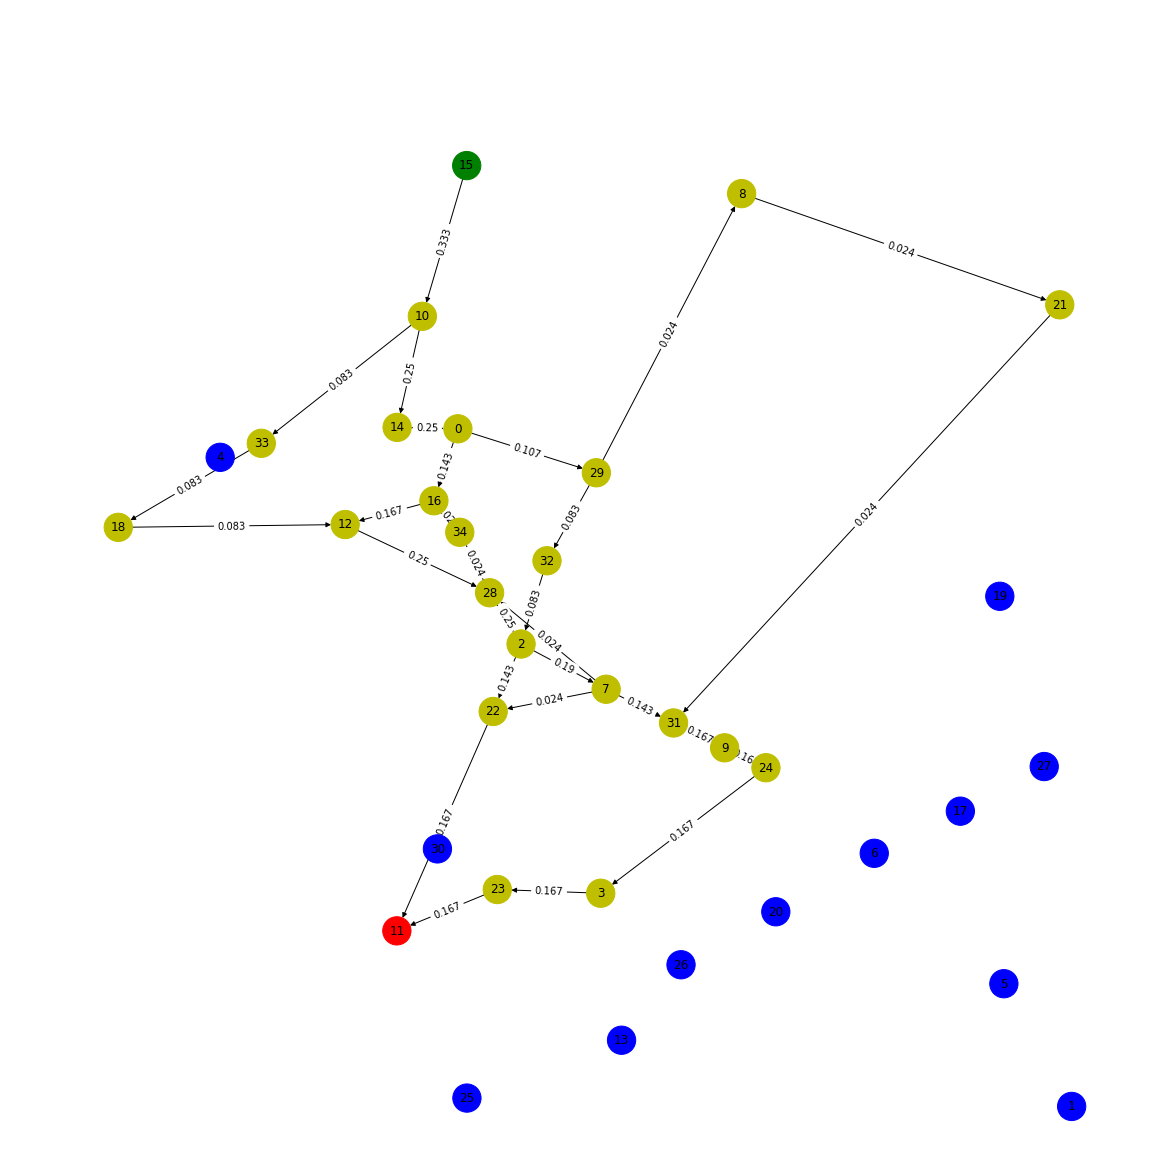

In [89]:
plt.figure(figsize=(16,16))
capacity_dic = nx.get_edge_attributes(graph_sol,'capacity')
colors = ['b']*35
for node in good_nodes:
    colors[node] = 'y'
colors[15] = 'g'
colors[11] = 'r'


nx.draw(graph_sol,pos_graph,
            node_size=800,
            labels=lab_dict, 
            with_labels = True,
            node_color = colors)

nx.draw_networkx_edge_labels(graph_sol,pos_graph,edge_labels=capacity_dic)

plt.show()